Importamos as bibliteca **pandas** e **matplotlib.pyplot** para auxiliar nos processos de manipulação, análise de dados e criação de gráficos para visualizações de dados.

In [82]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

Para realizar a leitura da base de dados, atribuimos a variável `data`:

In [83]:
# leitura do arquivo .csv
data = pandas.read_csv('PS_20174392719_1491204439457_log.csv')

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


A base de dados apresenta 11 colunas:
* `step`: Indica, em horas desde o inicio da observação, o momento em que a transação ocorre.
* `type`: Indica o tipo de transação.
* `amount`: Indica o valor envolvido na transação.
* `nameOrig`: Indica o nome da conta que realizou a transação.
* `oldbalanceOrg`: Indica o balanço da conta de origem da transação antes da operação ser realizada.
* `newbalanceOrig`: Indica o balanço da conta de origem da transação após a operação ser realizada.
* `nameDest`: Indica o nome da conta de destino da transação.
* `oldbalanceDest`: Indica o balanço da conta de destino da transação antes da operação ser realizada.
* `newbalanceDest`: Indica o balanço da conta de destino da transação após a operação ser realizada.
* `isFraud`: Indica se a operação foi realizada por um agente fraudulento.
* `isFlaggedFraud`: Indica se a operação movimenta um valor acima de 200 mil em uma única transação.

In [85]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Verificamos que não ocorrem valores nulos na base de dados.

Para listar as transações em grupos distintos, com a existência ou não de fraude, utilizamos a seguinte atribuição:

In [86]:
fraud_transactions     = data.loc[data['isFraud'] == 1]
non_fraud_transactions = data.loc[data['isFraud'] == 0]

Dado que o campo de nome descreve o tipo de conta envolvida na transação (comerciante ou cliente), precisamos saber o quão relevantes eles são para o problema. Para isso, faremos os seguintes testes:

In [87]:
amount_merchant_orig = len(data.loc[data['nameOrig'].str.match('M')])
amount_merchant_dest = len(data.loc[data['nameDest'].str.match('M')])
amount_fraud_orig_merchant = len(fraud_transactions.loc[fraud_transactions['nameOrig'].str.match('M')])
amount_fraud_dest_merchant = len(fraud_transactions.loc[fraud_transactions['nameDest'].str.match('M')])
amount_non_fraud_orig_merchant = len(non_fraud_transactions.loc[non_fraud_transactions['nameOrig'].str.match('M')])
amount_non_fraud_dest_merchant = len(non_fraud_transactions.loc[non_fraud_transactions['nameDest'].str.match('M')])

print('Quantidade de transações originadas de comerciantes:', amount_merchant_orig)
print('Quantidade de transações destinadas a comerciantes:', amount_merchant_dest)
print('Quantidade de transações fraudulentas originadas de comerciantes:', amount_fraud_orig_merchant)
print('Quantidade de transações fraudulentas destinadas a comerciantes:', amount_fraud_dest_merchant)
print('Quantidade de transações não fraudulentas originadas de comerciantes:', amount_non_fraud_orig_merchant)
print('Quantidade de transações não fraudulentas destinadas a comerciantes:', amount_non_fraud_dest_merchant)

Quantidade de transações originadas de comerciantes: 0
Quantidade de transações destinadas a comerciantes: 2151495
Quantidade de transações fraudulentas originadas de comerciantes: 0
Quantidade de transações fraudulentas destinadas a comerciantes: 0
Quantidade de transações não fraudulentas originadas de comerciantes: 0
Quantidade de transações não fraudulentas destinadas a comerciantes: 2151495


Podemos verificar que em todas as transações em que comerciantes aparecem, são destinatários e em nenhuma ocorre fraude. 
Essa informação é interessante para a árvore de decisão, então vamos simplificar os dados removendo as colunas de nome e adicionando uma nova coluna indicando quando uma transação envolve um comerciante.

In [88]:
data['hasMerchantAccount'] = numpy.where(data['nameDest'].str.match('M'), 1, 0)
reduced_data = data.drop(columns=['nameOrig', 'nameDest'])
reduced_data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hasMerchantAccount
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1


Como a coluna `step` indica horas desde o inicio da observação, vamos verificar como o número de transações está distribuído ao longo de dias.

In [89]:

stepAmounts = data.groupby('step').size().array
stepAmounts = numpy.array(stepAmounts, dtype=object)
stepAmounts = numpy.append(stepAmounts, 0)
stepAmounts = stepAmounts.reshape(24, int(numpy.ceil(len(stepAmounts)/24)))
stepAmounts = stepAmounts.astype(float)

Text(0.5, 69.0, 'dia')

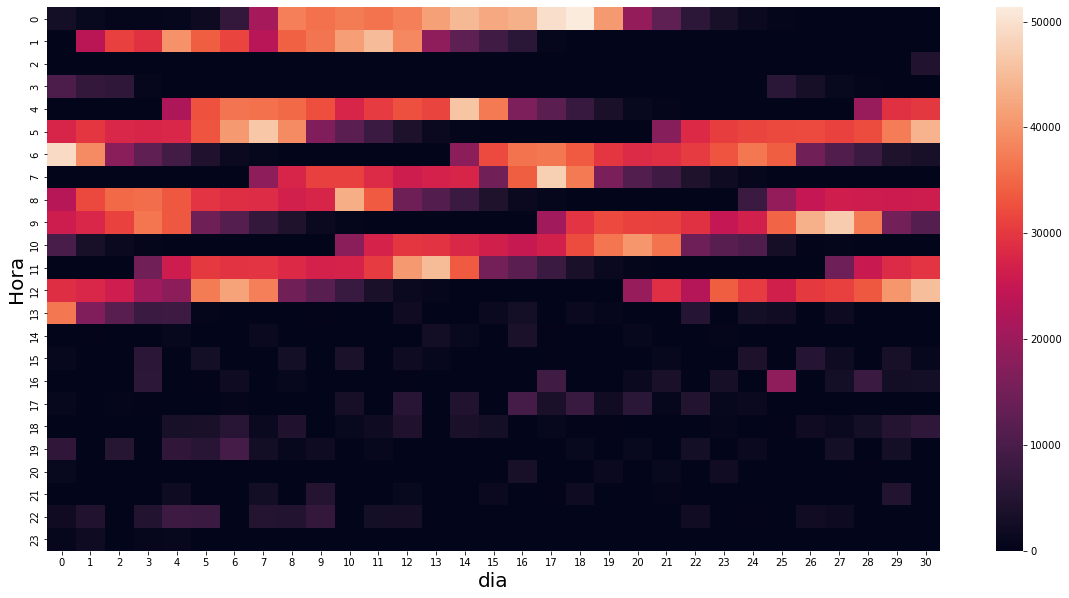

In [90]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = seaborn.heatmap(stepAmounts)
ax.set_ylabel('Hora', fontsize=20)
ax.set_xlabel('dia', fontsize=20)

Nós queremos que a árvore de decisão, ao receber uma transação qualquer, identifique se essa transação é ou não uma fraude, independente das transações anteriores ou de quando ela ocorre, logo não precisamos da coluna 'step' também.

In [ ]:
reduced_data = reduced_data.drop(columns=['step'])
reduced_data.head()